# Linear regression using LASSO

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as clt
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tueplots import bundles
from tueplots.constants.color import rgb

from utils import get_dataframe, get_astronomical_seasons
from plot_config import config

Load, clean and standardize data:

In [2]:
df = get_dataframe(solar_noon_altitudes=True, interpolate_data=True)
df.replace(-999, np.nan, inplace=True)
nan_indices = df.isna().any().index[df.isna().any()]
df[nan_indices] = df[nan_indices].interpolate(method='linear', axis=0)


X = df.drop(['RSKF', 'Datum und Uhrzeit', 'Gesamtanlage[kWh]'], axis=1) # Remove categorial feature, date and dependent variable.

scaler = StandardScaler()
scaler.fit(X)
X_standard = scaler.transform(X) # Standardize the features for correct regularization.

y = df['Gesamtanlage[kWh]']

In [3]:
# df['VPM'][1322:1326] # sanity check

Train linear regression model:

In [4]:
# (Based on https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html)

#alphas = np.logspace(-10, 5, 1000)  # alpha values to be chosen from by cross-validation
#reg = LassoCV(alphas=alphas, max_iter=100_000).fit(X_standard, y)
#alpha = reg.alpha_

In [5]:
alpha = 0.5 # Regularization factor
reg = Lasso(alpha).fit(X_standard, y)

In [6]:
coefficients = pd.DataFrame(data=reg.coef_, index=X.columns, columns=['all'])

print(coefficients)
print('Regularization factor: ', alpha)
print('R^2: ', reg.score(X_standard, y))

              all
FX       0.000000
FM       0.000000
RSK     -0.000000
SDK      6.082273
SHK_TAG -0.000000
NM       0.000000
VPM      0.000000
PM      -0.000000
TMK      0.255138
UPM     -1.234593
TXK      0.000000
TNK      0.000000
TGK      0.000000
SNA      6.828104
Regularization factor:  0.5
R^2:  0.9302760610846236


Plotting:

In [7]:
# Code taken from exploratory_analysis.ipynb and adapted:

In [8]:
from datetime import datetime

#data = get_dataframe(solar_noon_altitudes=True, interpolate_data=True)
data = df
# remove whitespace at beginning of column name
data.columns = [col.strip() for col in data.columns]
data.head()


# drop 29.02.2020 because there is no value in the other years to compare
data = data.drop(data[data['Datum und Uhrzeit'] == '29.02.2020'].index).reset_index()
data = data.drop('index', axis=1)

# add column for year, month and day of the year
# convert 'Datum und Uhrzeit' column to date
data['Date'] = [datetime.strptime(data['Datum und Uhrzeit'][i], '%d.%m.%Y') for i in range(len(data))]
data['Year'] = data['Date'].dt.year
data['Day of year'] = data['Date'].dt.dayofyear
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop('Date', axis=1)

For 2019 the MSE is 11.38.
For 2020 the MSE is 11.36.
For 2021 the MSE is 11.78.
For 2022 the MSE is 14.65.


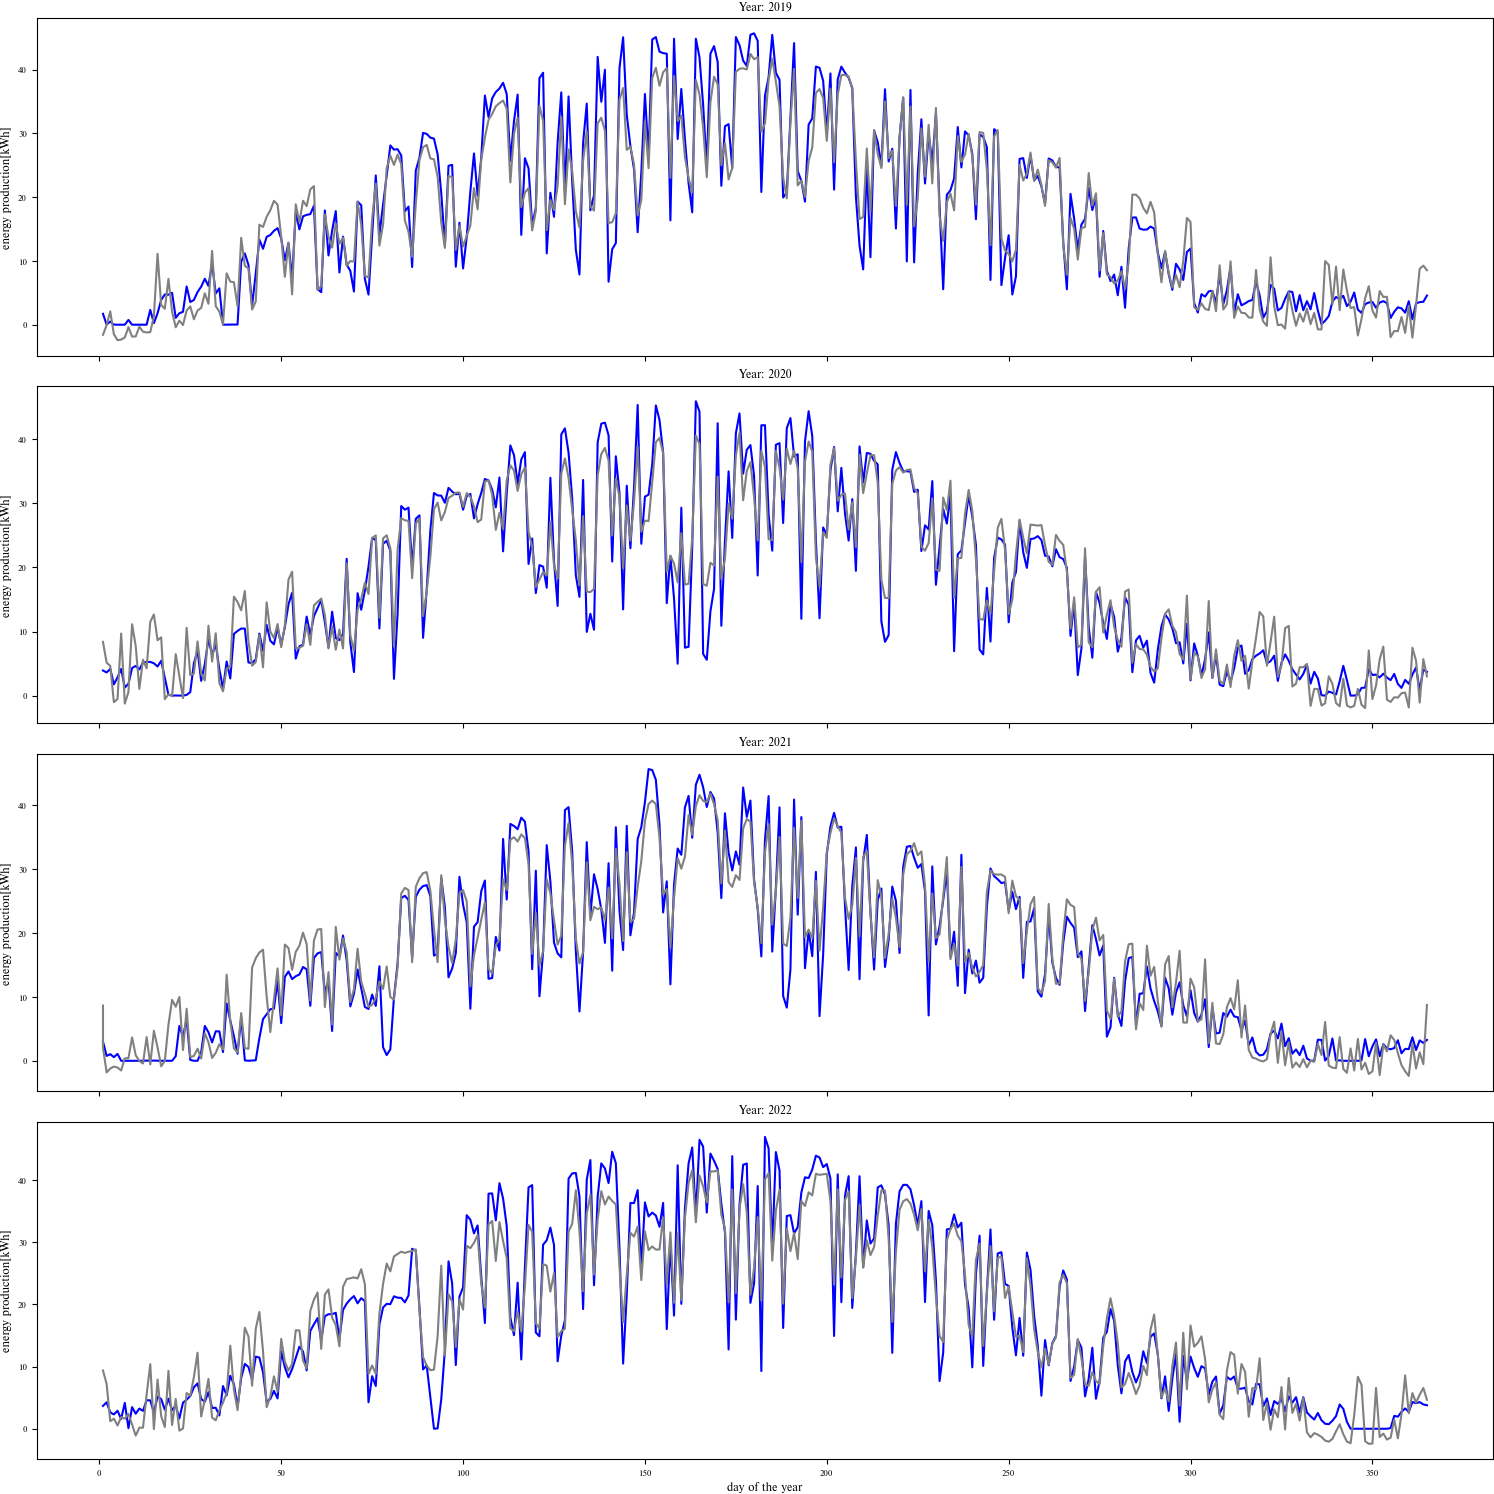

In [9]:
# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='half', nrows=4, ncols=1, usetex=False))

fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex=True)
i = 0
for year in data['Year'].unique():
    ax = axes.flatten()[i]
    ax.set_title('Year: ' + str(year))
    year_data = data[data['Year'] == year]

    X_year = year_data.drop(['RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Month', 'Day', 'Gesamtanlage[kWh]'], axis=1)
    X_year = scaler.transform(X_year)

    # plot energy production
    ax.plot(
        year_data['Day of year'],
        year_data['Gesamtanlage[kWh]'],
        color='blue'
    )

    #plot predictions
    ax.plot(
        year_data['Day of year'],
        reg.predict(X_year),
        color='grey'
    )
        
    ax.set_ylabel('energy production[kWh]')
    i += 1


    # compute mean squared error:
    mse = mean_squared_error(year_data['Gesamtanlage[kWh]'], reg.predict(X_year))
    print(f'For {year} the MSE is {mse:.2f}.')

    
axes[3].set_xlabel('day of the year')
plt.show()

Regression for individual seasons:

In [10]:
seasons = ['winter', 'spring', 'summer', 'fall']
data['Season'] = data.apply(get_astronomical_seasons, axis=1)

In [11]:
reg_by_season = {}
X_standard_by_season = {}
y_by_season = {}
scaler_by_season = {}

for season in seasons:
    data_season = data[data['Season'] == season]
    X_season = data_season.drop(['Season', 'RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Day', 'Month', 'Gesamtanlage[kWh]'], axis=1)
    scaler_season = StandardScaler()
    scaler_season.fit(X_season)
    X_season_standard = scaler_season.transform(X_season) # Standardize the features for correct regularization.
    y_season = data_season['Gesamtanlage[kWh]']

    alpha_season = alpha # Same regularization factor
    reg_season = Lasso(alpha_season).fit(X_season_standard, y_season)

    reg_by_season[season] = reg_season
    X_standard_by_season[season] = X_season_standard
    y_by_season[season] = y_season
    scaler_by_season[season] = scaler_season

Prepare data for plotting

In [12]:
# https://stackoverflow.com/questions/28931224/how-to-add-value-labels-on-a-bar-chart

# drop features set to zero in every season
for season in seasons:
    weights_temp = reg_by_season[season].coef_
    coefficients[season] = weights_temp
    

    


plotting_weights = coefficients.replace(0, np.nan)
plotting_weights = plotting_weights.dropna(how='all', axis=0)
plotting_weights = plotting_weights.replace(np.nan, 0)
plotting_weights.drop(columns=['all'], inplace=True)
plotting_weights['sort_val'] = plotting_weights.sum(axis=1)
plotting_weights = plotting_weights.sort_values(by='sort_val')
plotting_weights = plotting_weights.drop(columns=['sort_val'])

plotting_weights = plotting_weights.rename(index=config.abbrevs)

In [13]:
plotting_weights = plotting_weights.reindex(columns=['spring','summer','fall','winter'])
plotting_weights

,spring,summer,fall,winter
mean\n humidity,-0.822875,-1.403436,-1.310948,0.000000
snow,-0.657540,0.000000,0.000000,-0.127365
vapor\n pressure,0.000000,-0.378010,0.000000,0.000000
mean temp,0.546619,0.000000,0.000000,0.000000
max temp,0.303861,0.000000,0.000000,0.379379
solar angle,4.728340,0.416556,3.928032,0.449768
sunshine,5.089100,8.592598,4.943374,0.457443


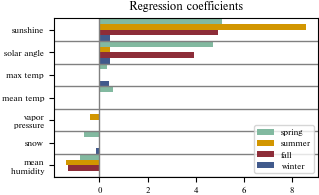

In [14]:
# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

plotting_features = list(plotting_weights.index)
colors=[rgb.tue_darkblue, rgb.tue_red, rgb.tue_orange, rgb.tue_lightgreen]

x = np.arange(plotting_weights.shape[0])  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for f, w in plotting_weights.iloc[:, ::-1].items():
    offset = width * multiplier
    rects = ax.barh(x + offset, w.values, width, label=f, color=colors[multiplier])
    multiplier += 1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Regression coefficients')
ax.set_yticks(x + (width * 1.5), plotting_features)
ax.legend(loc='lower right', ncols=1, reverse=True)
ax.axvline(x = 0, color = 'gray', lw=1)
for y in x:
    ax.axhline(y=y-(width*0.5), color='gray', lw=1)
ax.set_ylim(0 - width/2, len(plotting_features) - width/2)

plt.savefig('../report/fig/regression.pdf')
plt.show()

In [15]:
def reg_using_season(row):
    season = row['Season']
    sample = row.drop(['Season'])
    sample = scaler_by_season[season].transform(pd.DataFrame([sample]))
    return reg_by_season[season].predict(sample)

For 2019 the MSE is 7.61.
For 2020 the MSE is 6.51.
For 2021 the MSE is 6.88.
For 2022 the MSE is 9.09.


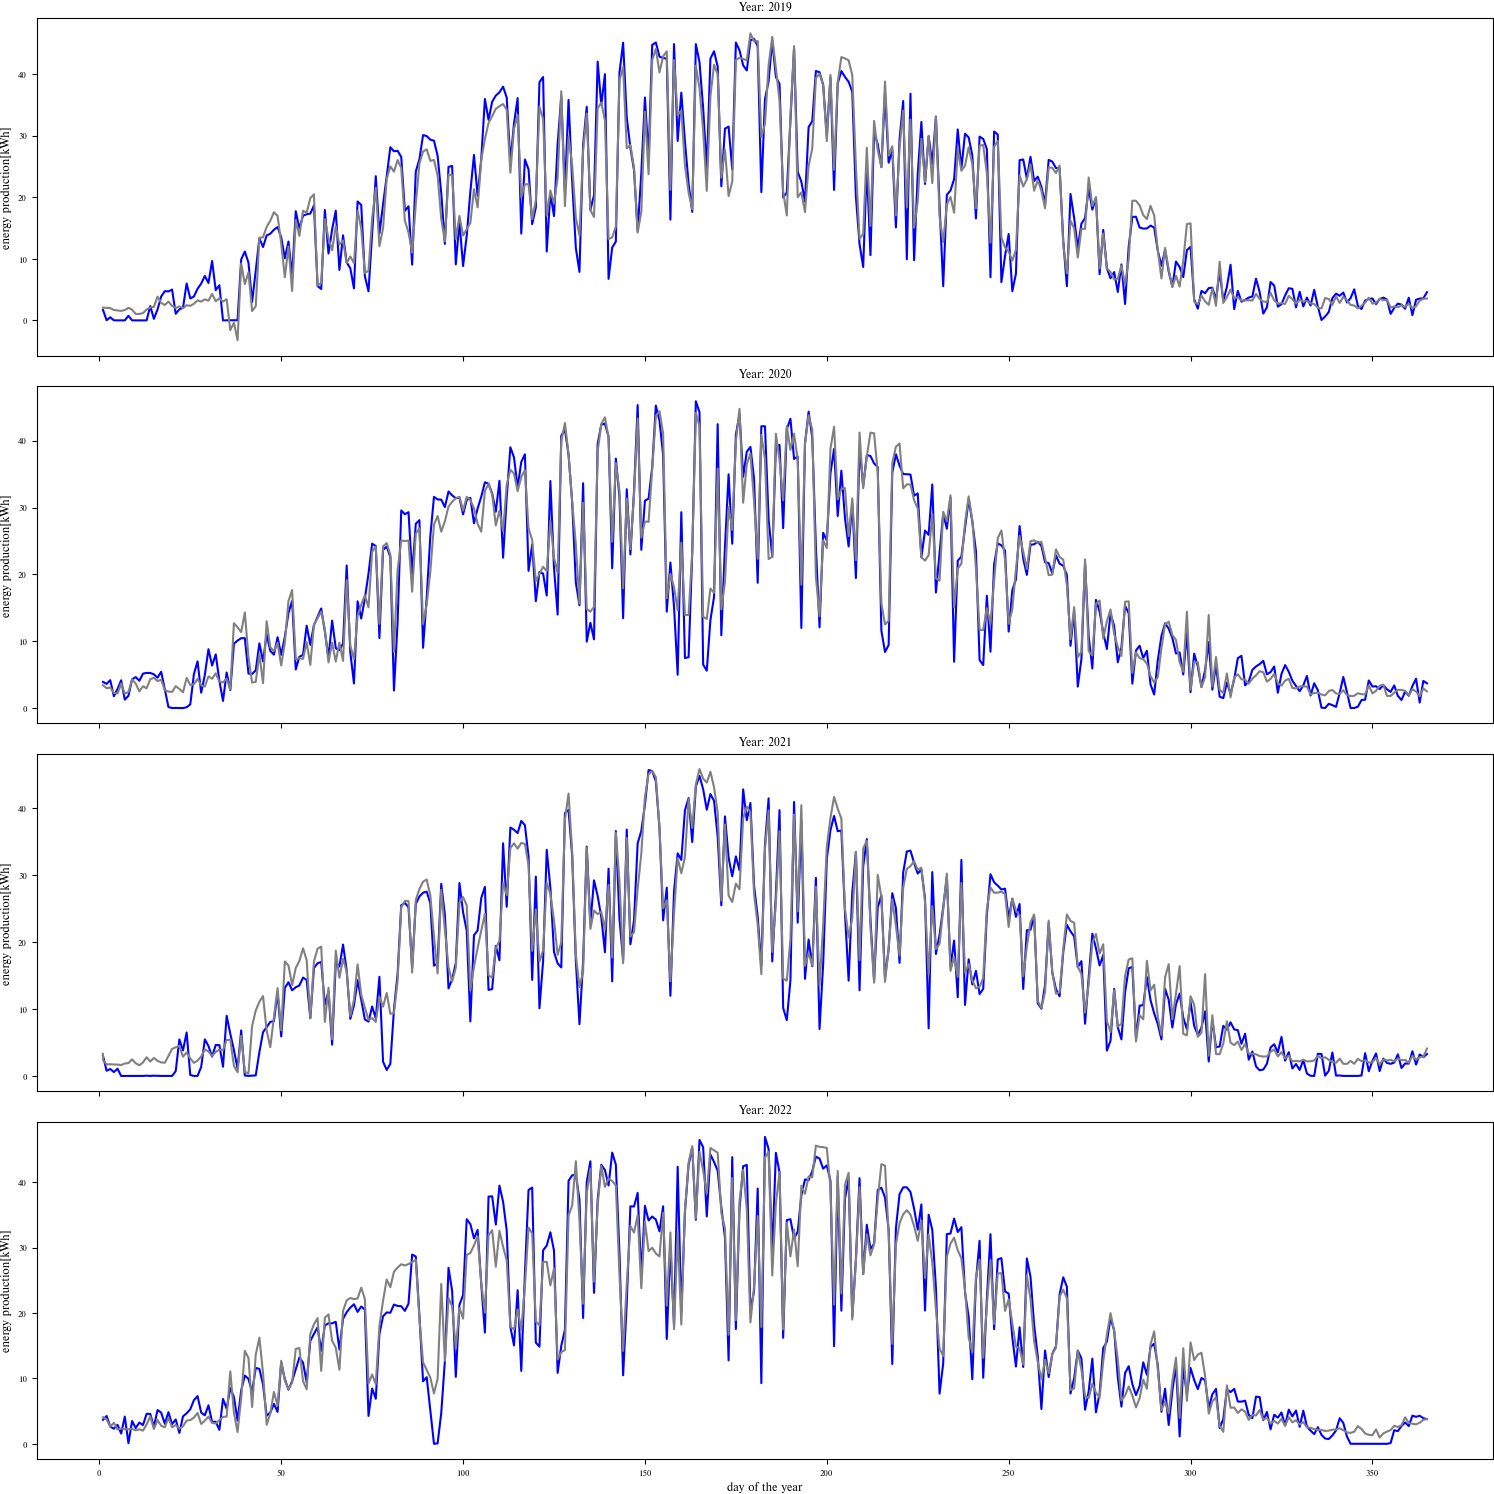

In [16]:
# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='half', nrows=4, ncols=1, usetex=False))

fig, axes = plt.subplots(4, 1, figsize=(15,15), sharex=True)
i = 0

for year in data['Year'].unique():
    ax = axes.flatten()[i]
    ax.set_title('Year: ' + str(year))
    year_data = data[data['Year'] == year]

    # plot energy production
    ax.plot(
        year_data['Day of year'],
        year_data['Gesamtanlage[kWh]'],
        color='blue'
    )

    X_year = year_data.drop(['RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Day', 'Month', 'Gesamtanlage[kWh]'], axis=1)
    pred_using_season = X_year.apply(reg_using_season, axis=1)

    #plot predictions
    ax.plot(
        year_data['Day of year'],
        pred_using_season,
        color='grey'
        )
        
    ax.set_ylabel('energy production[kWh]')
    i += 1


    # compute mean squared error:
    mse = mean_squared_error(year_data['Gesamtanlage[kWh]'], pred_using_season)
    print(f'For {year} the MSE is {mse:.2f}.')

    
axes[3].set_xlabel('day of the year')
plt.show()

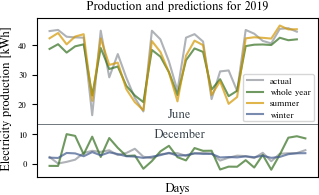

In [17]:
# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

year = 2019
months = [6,12]

fig, ax = plt.subplots(1, 1)

plt.xlabel('Days')
plt.ylabel(config.labels.production)
plt.xticks([])
ax.set_title('Production and predictions for ' + str(year))

for i,month in enumerate(months):
    month_data = data[(data['Year'] == year) & (data['Month'] == month)]

    # plot production:
    ax.plot(
        month_data['Day'],
        month_data['Gesamtanlage[kWh]'],
        color=rgb.tue_gray,
        label='actual'
        )

    X_month = month_data.drop(['RSKF', 'Datum und Uhrzeit', 'Year', 'Day of year', 'Day', 'Month', 'Gesamtanlage[kWh]'], axis=1)
    pred_using_season = X_month.apply(reg_using_season, axis=1)

    # plot predictions
    ax.plot(
        month_data['Day'],
        reg.predict(scaler.transform(X_month.drop('Season', axis=1))),
        color=rgb.tue_darkgreen,
        label='whole year',
        alpha=0.7
        )

    ax.plot(
        month_data['Day'],
        pred_using_season,
        color=[rgb.tue_orange, rgb.tue_darkblue][i],
        label=['summer', 'winter'][i],
        alpha=0.7
        )

fig.text(0.56, 0.40, 'June', ha='center', c=rgb.tue_dark)
fig.text(0.56, 0.30, 'December', ha='center', c=rgb.tue_dark)
ax.axhline(y=13.5, color=rgb.tue_dark, lw=0.5, ls='-')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best')

plt.savefig('../report/fig/predictions.pdf')
plt.show()

Check variability of the coefficients

In [18]:
from sklearn.model_selection import RepeatedKFold, cross_validate
import seaborn as sns

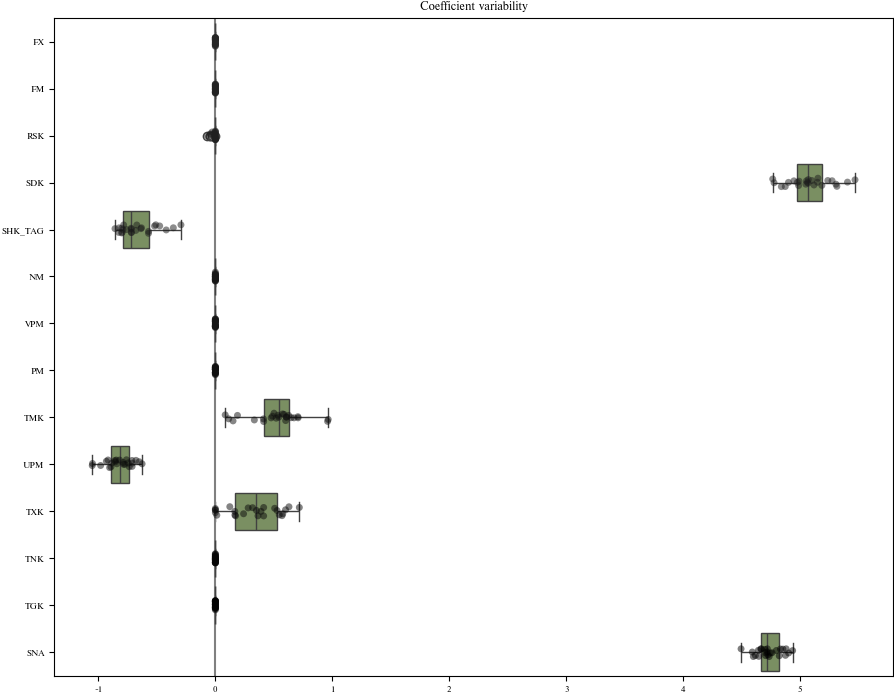

In [19]:
# Based on https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html

season = 'spring' # change season here

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=0)

cv_model = cross_validate(Lasso(0.5), X_standard_by_season[season], y_by_season[season], cv=cv, return_estimator=True, n_jobs=2,)
coefs = pd.DataFrame([est.coef_ for est in cv_model['estimator']], columns=X.columns)

plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', palette='dark:k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color=rgb.tue_green, saturation=0.5, whis=100)
plt.axvline(x=0, color='.5')
plt.title('Coefficient variability')
plt.rc('axes', unicode_minus=False)

plt.show()

In [20]:
coefs

,FX,FM,RSK,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,SNA
0,0.0,0.0,-0.005381,5.314380,-0.671881,0.0,0.0,-0.0,0.959598,-0.626646,0.000000,0.0,0.0,4.735110
1,0.0,0.0,-0.000000,5.152368,-0.717654,0.0,0.0,-0.0,0.707437,-0.760628,0.241171,0.0,0.0,4.705028
2,-0.0,-0.0,-0.000000,4.839670,-0.294342,0.0,0.0,-0.0,0.150991,-1.052879,0.507111,0.0,0.0,4.901843
3,0.0,0.0,-0.000000,5.068777,-0.824093,0.0,0.0,-0.0,0.189000,-0.904206,0.546461,0.0,0.0,4.665065
4,-0.0,-0.0,-0.000000,5.048787,-0.759369,0.0,0.0,-0.0,0.587068,-0.785836,0.317895,0.0,0.0,4.646749
5,0.0,0.0,-0.042067,4.946973,-0.825537,0.0,0.0,-0.0,0.534973,-0.774500,0.576155,0.0,0.0,4.617247
6,-0.0,-0.0,-0.000000,4.975894,-0.509433,0.0,0.0,-0.0,0.672631,-0.917738,0.166258,0.0,0.0,4.717520
7,0.0,0.0,-0.000000,5.306420,-0.571683,0.0,0.0,-0.0,0.476957,-0.932216,0.166851,0.0,0.0,4.600092
8,0.0,0.0,-0.000000,5.236589,-0.797312,0.0,0.0,-0.0,0.705793,-0.712957,0.012442,0.0,0.0,4.936035
9,-0.0,-0.0,-0.000000,4.986933,-0.636990,0.0,0.0,-0.0,0.333280,-0.745847,0.570324,0.0,0.0,4.796693
